In [72]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [98]:
def reorganize_and_save_temporal_spatial_data(input_folder, output_folder):
    """
    Reorganize and save temporal and spatial gait data for participants.
    
    Parameters:
    - input_folder: Path to the folder containing gait data .mat files for each participant.
    - output_folder: Path to the folder where reorganized data will be saved.
    """
    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Iterate over files in the input folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.mat'):
            # Load .mat file
            file_path = os.path.join(input_folder, file_name)
            data = sio.loadmat(file_path)
            
            # Extract relevant gait parameters
            try:
                participant_data = {}
                for gait_key in data['Par'].dtype.names:
                    gait_data = data['Par'][gait_key][0, 0]
                    parameters = gait_data['Parameters'][0, 0]
                    
                    # Extract right, left, and combined parameters
                    right_params = parameters['right'][0, 0]
                    left_params = parameters['left'][0, 0]
                    combined_params = parameters['combined'][0, 0]
                    
                    participant_data[gait_key] = {
                        'right_leg': {
                            'cadence': np.array(right_params['cadence']).flatten(),
                            'stride_duration': np.array(right_params['strideDuration']).flatten(),
                            'stance_phase': np.array(right_params['stancePhase']).flatten(),
                            'swing_phase': np.array(right_params['swingPhase']).flatten(),
                            'stride_length': np.array(right_params['strideLength']).flatten(),
                            'heel_idx': np.array(right_params['heelIdx']).flatten(),
                            'toe_idx': np.array(right_params['toeIdx']).flatten()
                        },
                        'left_leg': {
                            'cadence': np.array(left_params['cadence']).flatten(),
                            'stride_duration': np.array(left_params['strideDuration']).flatten(),
                            'stance_phase': np.array(left_params['stancePhase']).flatten(),
                            'swing_phase': np.array(left_params['swingPhase']).flatten(),
                            'stride_length': np.array(left_params['strideLength']).flatten(),
                            'heel_idx': np.array(left_params['heelIdx']).flatten(),
                            'toe_idx': np.array(left_params['toeIdx']).flatten()
                        },
                        'combined': {
                            'cadence': np.array(combined_params['cadence']).flatten(),
                            'stride_duration': np.array(combined_params['strideDuration']).flatten(),
                            'stance_phase': np.array(combined_params['stancePhase']).flatten(),
                            'swing_phase': np.array(combined_params['swingPhase']).flatten(),
                            'right_step_length': np.array(combined_params['rightStepLength']).flatten(),
                            'left_step_length': np.array(combined_params['leftStepLength']).flatten(),
                            'right_step_time': np.array(combined_params['rightStepTime']).flatten(),
                            'left_step_time': np.array(combined_params['leftStepTime']).flatten(),
                            'step_length': np.array(combined_params['stepLength']).flatten(),
                            'step_duration': np.array(combined_params['stepDuration']).flatten(),
                            'right_double_support_time': np.array(combined_params['rightDoubleSupportTime']).flatten(),
                            'left_double_support_time': np.array(combined_params['leftDoubleSupportTime']).flatten(),
                            'right_single_support_time': np.array(combined_params['rightSingleSupportTime']).flatten(),
                            'left_single_support_time': np.array(combined_params['leftSingleSupportTime']).flatten(),
                            'r_step_width': np.array(combined_params['RstepWidth']).flatten(),
                            'l_step_width': np.array(combined_params['LstepWidth']).flatten()
                        },
                        'avg_velocity': np.array(parameters['avgVelocity']).flatten(),
                        'distance_traveled': np.array(gait_data['distanceTraveled']).flatten(),
                        'inst_velocity': np.array(gait_data['instVelocity']).flatten()
                    }
                
                # Save the reorganized data in the output folder as a .pkl file
                output_file_name = file_name.replace('.mat', '_reorganized.pkl')
                output_file_path = os.path.join(output_folder, output_file_name)
                
                with open(output_file_path, 'wb') as f:
                    pickle.dump(participant_data, f)
            except KeyError as e:
                print(f"KeyError: {e} in file {file_name}")


In [114]:
def concatenate_temporal_spatial_data(input_folder, output_file):
    """
    Concatenate temporal and spatial gait data from multiple participants and save in a single file.
    
    Parameters:
    - input_folder: Path to the folder containing reorganized gait data .pkl files for each participant.
    - output_file: Path to save the concatenated data.
    """
    concatenated_data = {
        'right_leg': {},
        'left_leg': {},
        'combined': {},
        'avg_velocity': [],
        'distance_traveled': [],
        'inst_velocity': []
    }
    
    # Initialize dictionaries to store concatenated lists for each parameter
    for leg in ['right_leg', 'left_leg', 'combined']:
        concatenated_data[leg] = {
            'cadence': [],
            'stride_duration': [],
            'stance_phase': [],
            'swing_phase': [],
            'stride_length': [],
            'heel_idx': [],
            'toe_idx': [],
            'right_step_length': [],
            'left_step_length': [],
            'right_step_time': [],
            'left_step_time': [],
            'step_length': [],
            'step_duration': [],
            'right_double_support_time': [],
            'left_double_support_time': [],
            'right_single_support_time': [],
            'left_single_support_time': [],
            'r_step_width': [],
            'l_step_width': []
        }
    
    # Iterate over files in the input folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith('_reorganized.pkl'):
            # Load .pkl file
            file_path = os.path.join(input_folder, file_name)
            print('Processing File = ', file_path)
            with open(file_path, 'rb') as f:
                participant_data = pickle.load(f)
                
                # Concatenate data across participants and trials
                for gait_key, gait_data in participant_data.items():
                    for leg in ['right_leg', 'left_leg', 'combined']:
                        if leg in gait_data:
                            for key, value in gait_data[leg].items():
                                flat_value = deep_flatten(value)
                                concatenated_data[leg][key].extend(flat_value)
                    concatenated_data['avg_velocity'].extend(deep_flatten(gait_data['avg_velocity']))
                    concatenated_data['distance_traveled'].extend(deep_flatten(gait_data['distance_traveled']))
                    concatenated_data['inst_velocity'].extend(deep_flatten(gait_data['inst_velocity']))
                    
    # Apply post-processing corrections
    concatenated_data = post_process_data(concatenated_data)
    
    # Save the concatenated data in the output file
    with open(output_file, 'wb') as f:
        pickle.dump(concatenated_data, f)
    
    # Print concatenated data info
    print(f"Concatenation complete. Data for headers:")
    for leg in concatenated_data:
        if isinstance(concatenated_data[leg], dict):
            for key in concatenated_data[leg]:
                print(f"Leg: {leg}, Parameter: {key}, Number of entries: {len(concatenated_data[leg][key])}")
        else:
            print(f"Parameter: {leg}, Number of entries: {len(concatenated_data[leg])}")
    
    # Visualize each header as a histogram
    for leg in concatenated_data:
        if isinstance(concatenated_data[leg], dict):
            for key in concatenated_data[leg]:
                if len(concatenated_data[leg][key]) > 0:  # Check if the list is non-empty before plotting
                    try:
                        plt.figure()
                        plt.hist(np.array(concatenated_data[leg][key]).flatten(), bins=20, edgecolor='black')
                        plt.xlabel(key)
                        plt.ylabel('Frequency')
                        plt.title(f'Histogram of {key} for {leg}')
                        plt.show()
                    except ValueError as e:
                        print(f"ValueError: {e} for {leg} - {key}")
                        print(f"Data shape: {concatenated_data[leg][key]}")
                        print(f"Data: {concatenated_data[leg][key]}")
        else:
            if len(concatenated_data[leg]) > 0:  # Check if the list is non-empty before plotting
                
                plt.figure()
                plt.hist(np.array(concatenated_data[leg]).flatten(), bins=20, edgecolor='black')
                plt.xlabel(leg)
                plt.ylabel('Frequency')
                plt.title(f'Histogram of {leg}')
                plt.show()


In [115]:
def deep_flatten(data):
    """
    Recursively flatten a nested list or numpy array.
    
    Parameters:
    - data: The data to flatten, which can be a list or numpy array.
    
    Returns:
    - A flattened list containing all elements.
    """
    flat_list = []
    if isinstance(data, (list, np.ndarray)):
        for item in data:
            flat_list.extend(deep_flatten(item))
    else:
        flat_list.append(data)
    return flat_list

In [116]:
def post_process_data(data):
    """
    Apply post-processing corrections to the concatenated data.
    
    Parameters:
    - data: Dictionary containing the concatenated gait data.
    
    Returns:
    - The corrected data.
    """
    # Ensure that right_single_support_time and left_single_support_time are absolute values
    for leg in ['combined']:
        if 'right_single_support_time' in data[leg]:
            data[leg]['right_single_support_time'] = [abs(x) for x in data[leg]['right_single_support_time']]
        if 'left_single_support_time' in data[leg]:
            data[leg]['left_single_support_time'] = [abs(x) for x in data[leg]['left_single_support_time']]
    
    return data

Processing File =  F:\AlterG\TemporoSpatial\Norm\GaitParameters01_reorganized.pkl
Processing File =  F:\AlterG\TemporoSpatial\Norm\GaitParameters02_reorganized.pkl
Processing File =  F:\AlterG\TemporoSpatial\Norm\GaitParameters03_reorganized.pkl
Processing File =  F:\AlterG\TemporoSpatial\Norm\GaitParameters04_reorganized.pkl
Processing File =  F:\AlterG\TemporoSpatial\Norm\GaitParameters05_reorganized.pkl
Processing File =  F:\AlterG\TemporoSpatial\Norm\GaitParameters06_reorganized.pkl
Processing File =  F:\AlterG\TemporoSpatial\Norm\GaitParameters07_reorganized.pkl
Processing File =  F:\AlterG\TemporoSpatial\Norm\GaitParameters08_reorganized.pkl
Processing File =  F:\AlterG\TemporoSpatial\Norm\GaitParameters09_reorganized.pkl
Processing File =  F:\AlterG\TemporoSpatial\Norm\GaitParameters10_reorganized.pkl
Processing File =  F:\AlterG\TemporoSpatial\Norm\GaitParameters11_reorganized.pkl
Processing File =  F:\AlterG\TemporoSpatial\Norm\GaitParameters12_reorganized.pkl
Processing File 

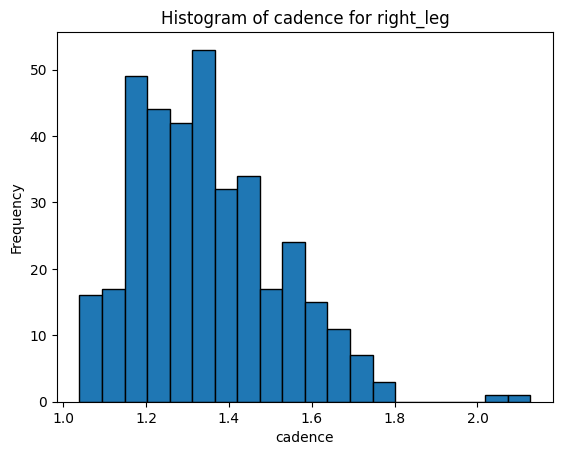

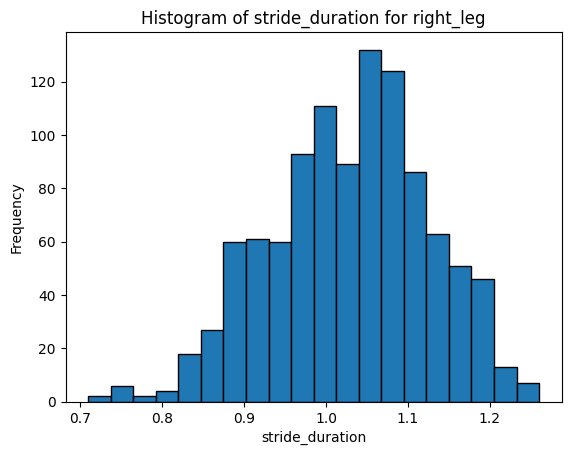

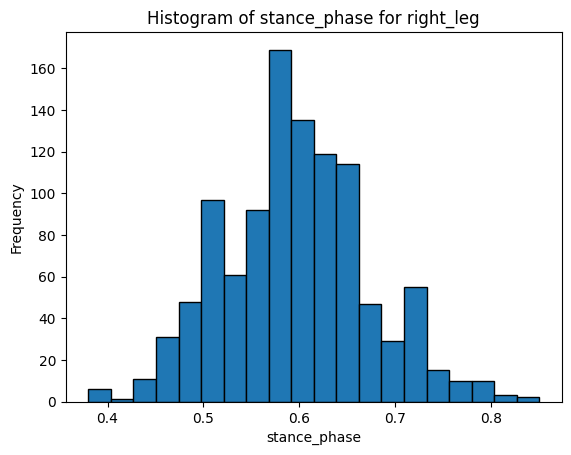

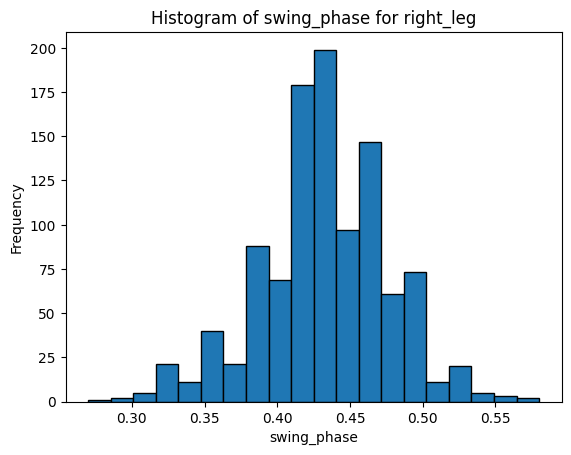

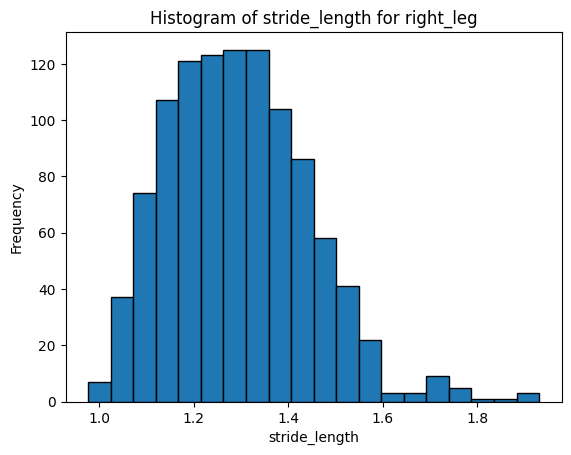

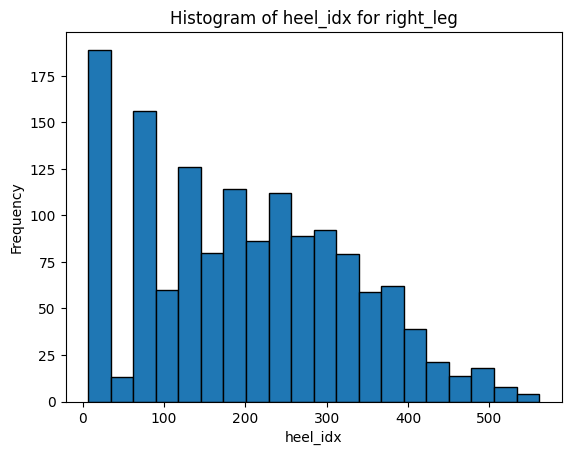

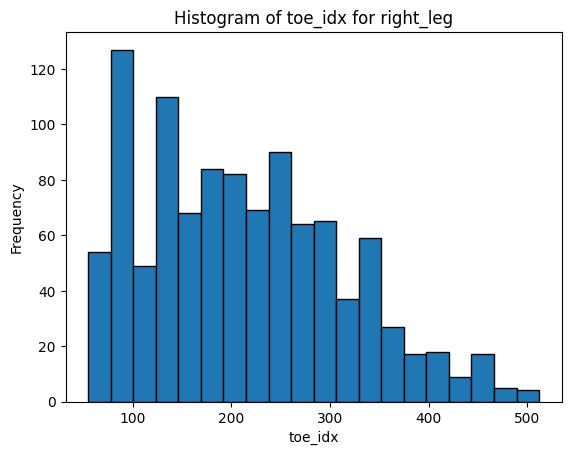

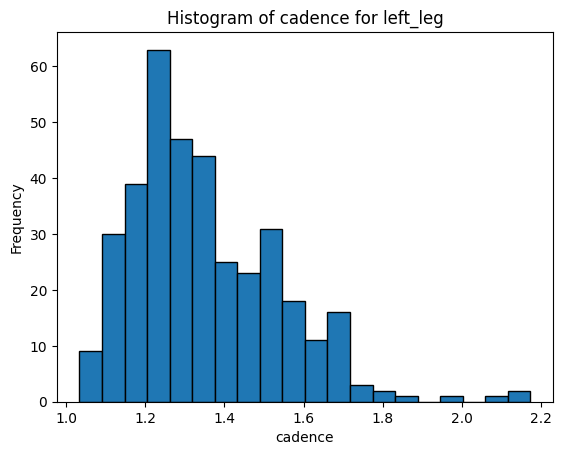

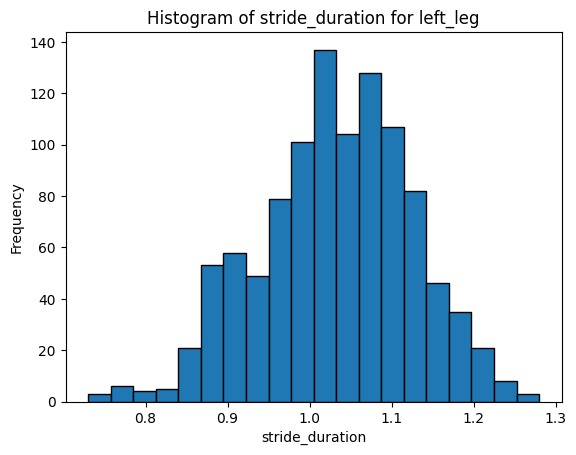

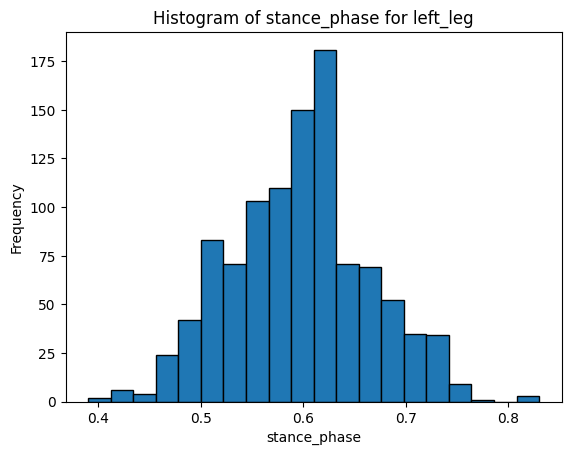

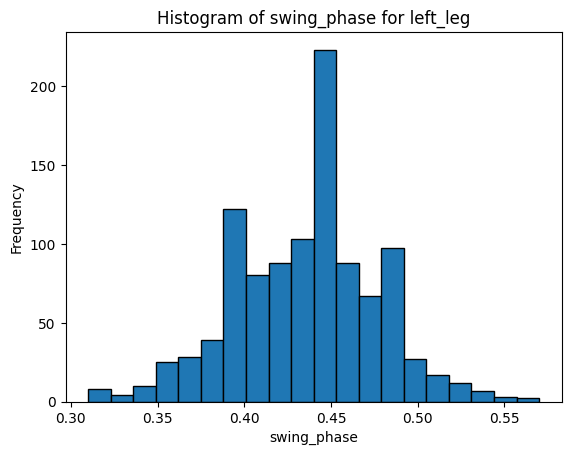

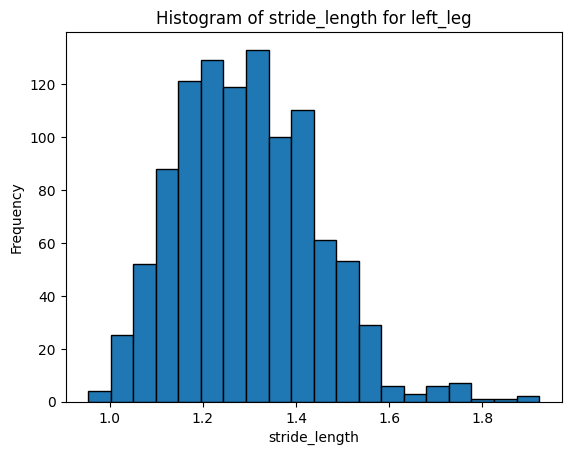

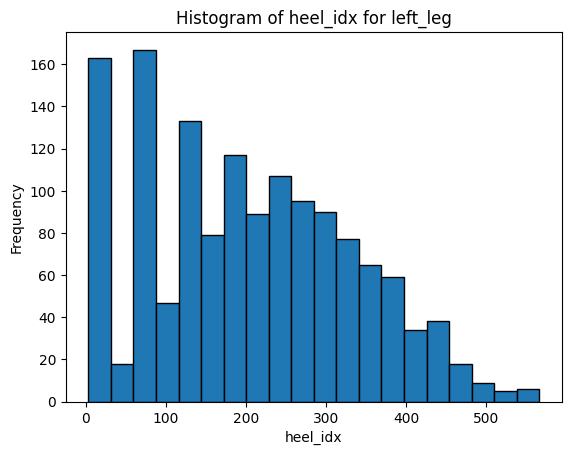

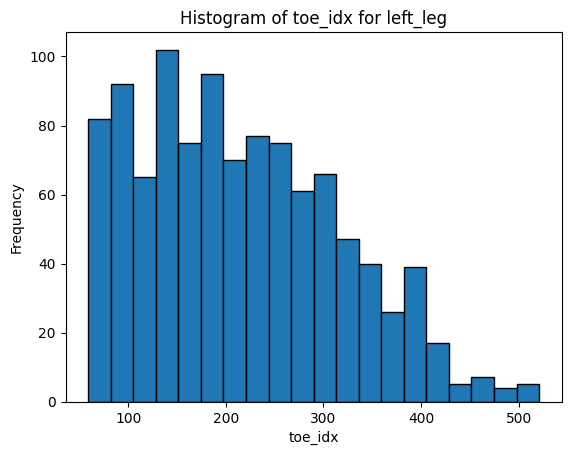

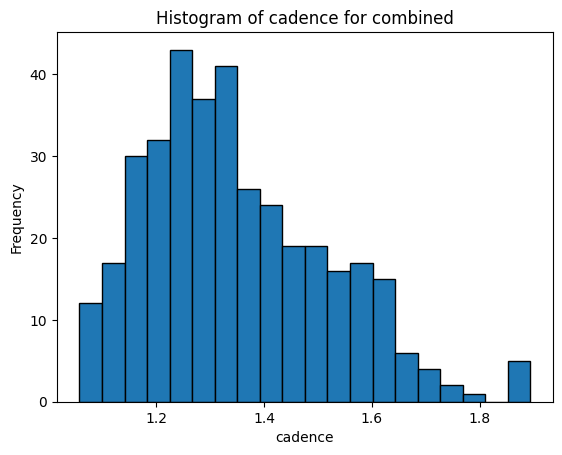

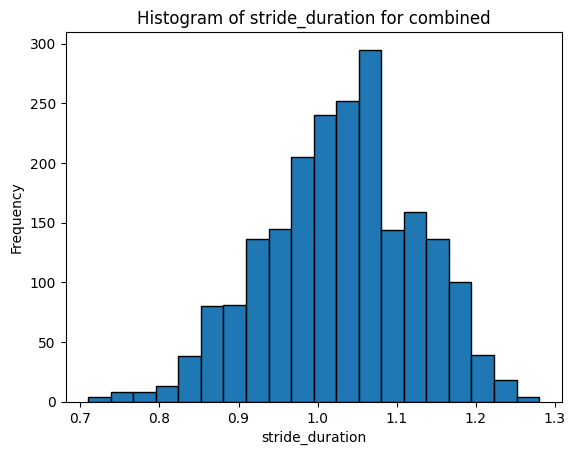

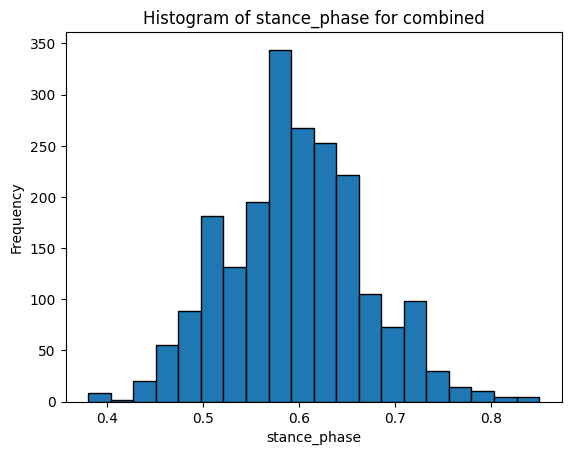

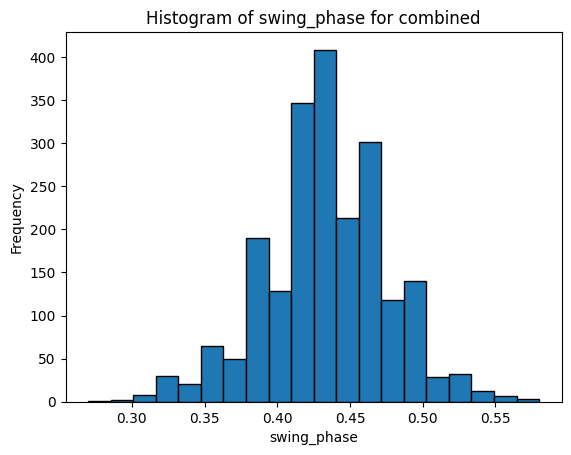

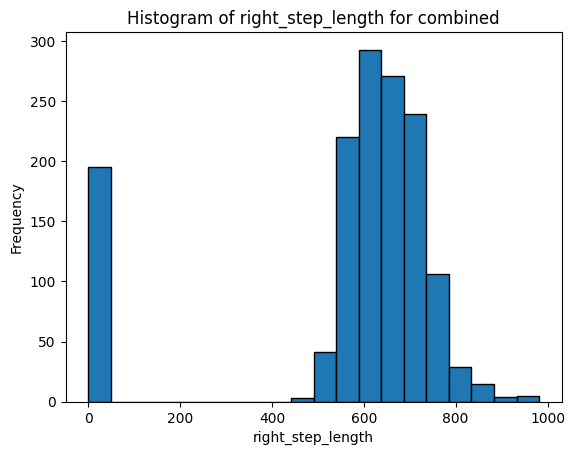

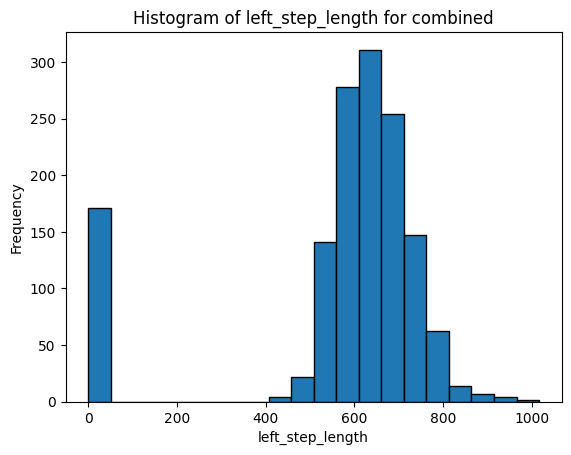

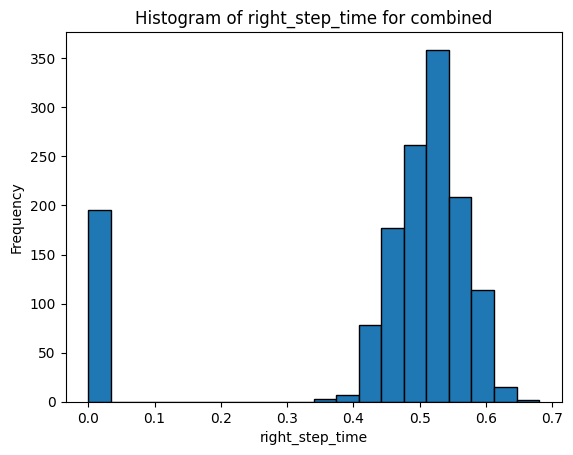

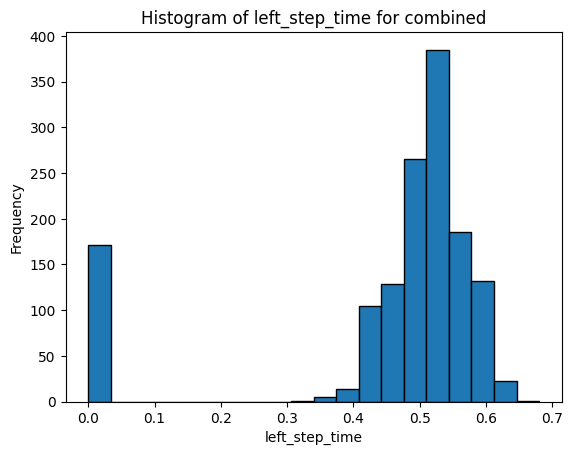

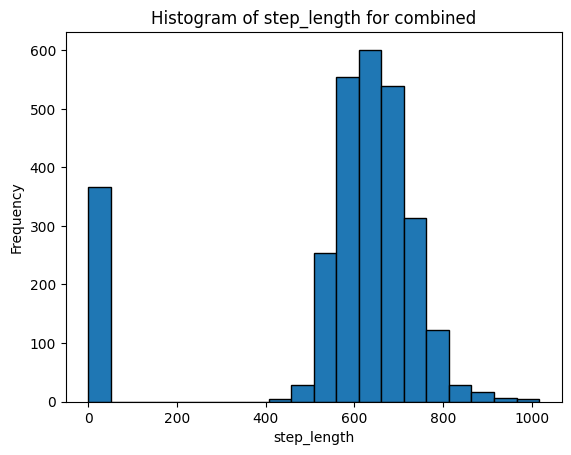

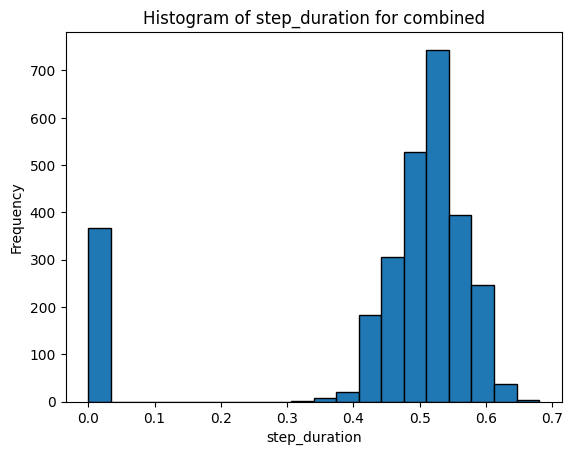

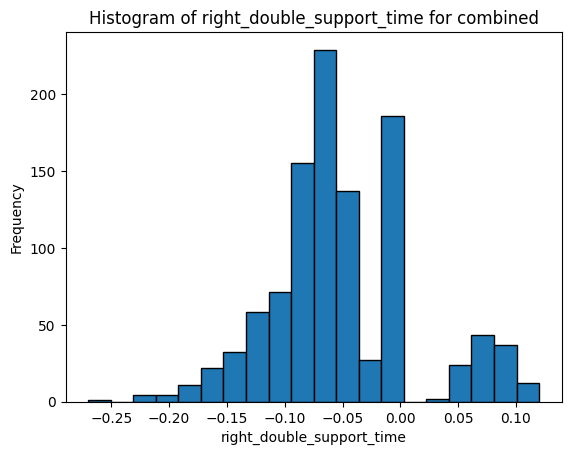

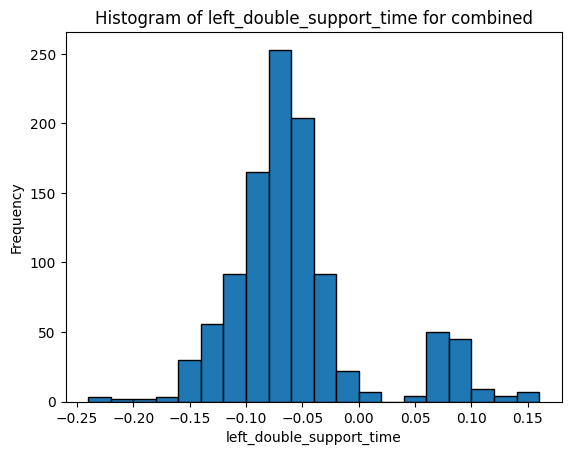

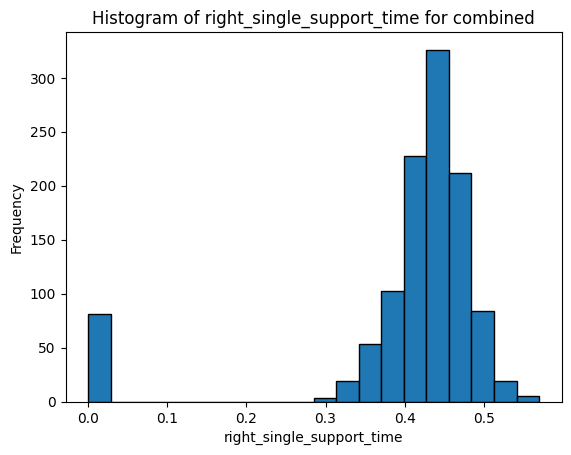

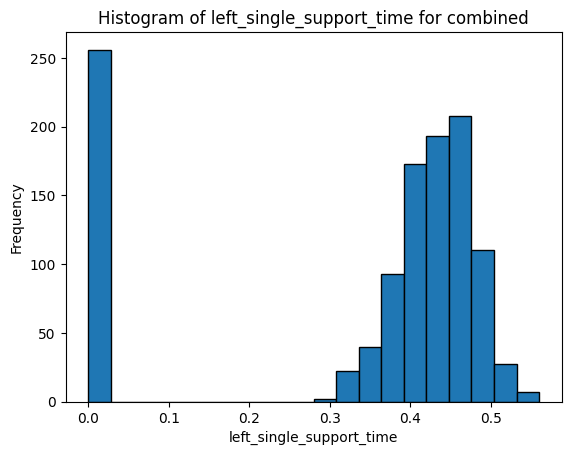

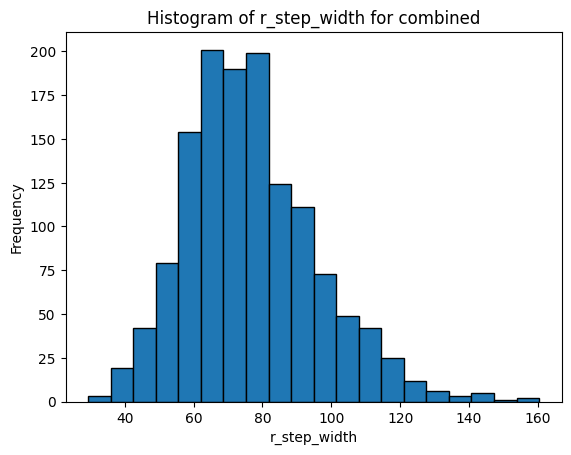

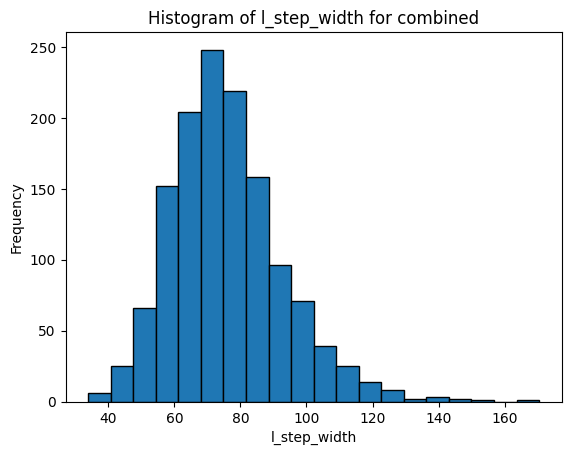

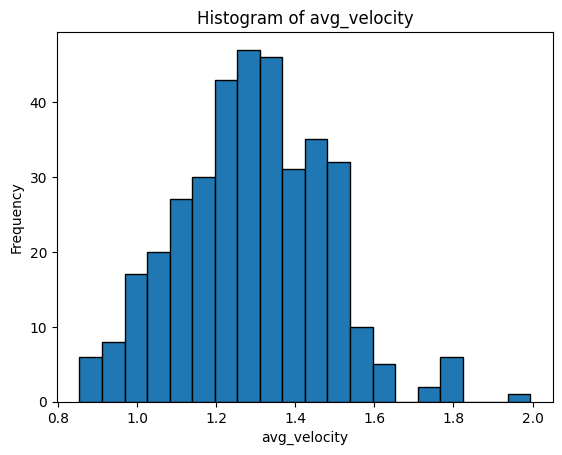

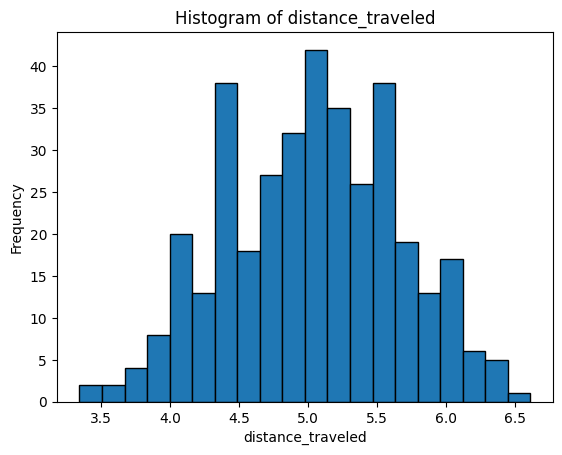

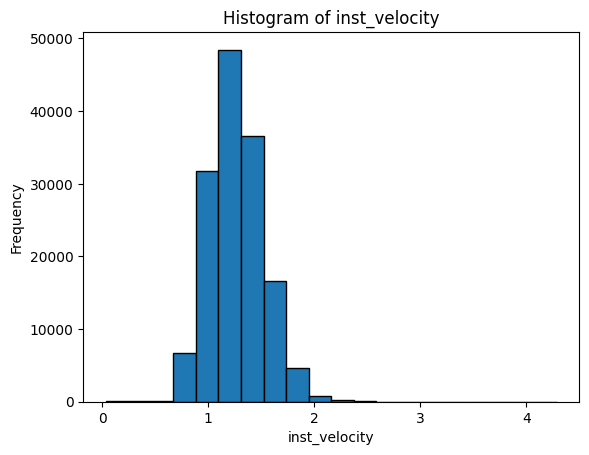

In [117]:
# Example Usage
input_folder = r'F:\AlterG\Control\TempSpatial\Gait'
output_folder = r'F:\AlterG\TemporoSpatial\Norm'
output_file = r'F:\AlterG\TemporoSpatial\ConcatenatedNorm\Concatenated_Gait_Data.pkl'
reorganize_and_save_temporal_spatial_data(input_folder, output_folder)
concatenate_temporal_spatial_data(output_folder, output_file)